# Fake Painter

[chainer-goph](https://github.com/mattya/chainer-gogh) に啓発されて作ってみました。

動作環境
- Windows, MacOS, Linux で動作確認済み。いずれも Anaconda
- chainer 2.0
- python3.6 （3.5でもよい）
- opencv 3.2 (3.0でもよい。２でもよいかも） PILだけでも書けると思うが、本人が PIL より慣れてるためちょっとだけ使った。 

chainer-goph との違いは、元の色合いに似せる項を追加していること。
最初原画をかなりぼかした画像と、生成画像をぼかした画像の距離を評価関数にしていたが、そこまでしなくてもいいという結論に達した。
ぼかすのは、この項が聞きすぎるとスタイル感が出ないかと思ったからだが、結局そのあたりは重みを調整すればよさそうである。

In [178]:
from chainer import links as L
import chainer.functions as F
import chainer
from chainer import Chain, Link
from chainer import Parameter
from chainer.links import VGG16Layers
from chainer.links.model.vision.vgg import prepare as VGGprepare
from chainer import Variable, optimizers
import numpy as np
import PIL.Image
from PIL import ImageFilter
from io import BytesIO
import urllib.request
import cv2

from IPython.html.widgets import FloatProgress
from IPython.display import display

mean = [103.939, 116.779, 123.68]   # BGR
#  modelVGG = VGG16Layers()

from IPython.display import clear_output, Image, display
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [2]:
# 基本入出力関数

# url を指定して画像を読み込み
def url2img(url):
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    img =PIL.Image.fromarray(img[:, :, ::-1].copy())
    return img

# 配列の表示
def showarray(a, fmt='jpeg'):  # numpy 配列としての画像を表示
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# blob データを PIL 画像に変換
def blob2img(blob, mean=mean):
    blob = (np.dstack(blob)+ mean)[:,:,::-1]   # BGR 2 RGB
    return PIL.Image.fromarray(np.uint8(np.clip(blob,0,255)))

# blob データを画像として保存
def save_image(blobimg, it, fn = "frames",mean =mean):
    image = blob2img(blobimg, mean=mean)
    image.save(fn+"/im_%05d.png"%it)
    return image

# チャネル間の相関行列
def ch_corr_matrix(ld):
    # 0次元目はバッチ数
    ch = ld.shape[1] # チャネル数
    size = ld[0][0].size  # チャネルあたりのデータ数
    cmatrix = F.reshape(ld, (ch,size)) # チャネルごとに１次元化した ch x size の配列を作る
    matrix = F.matmul(cmatrix, cmatrix,transb=True) / np.float32(ch*size) # 相関行列
    return matrix

In [3]:
# layers_for_orig = ["conv4_1", "conv4_2", "conv4_3", "pool4"]
# layers_for_style =["conv1_1", "conv1_2", "pool1", "conv2_1", "conv2_2", "pool2", "conv3_1", "conv3_2", "conv3_3v3","pool3"]

lr = np.float32(400.0) # 学習係数
rr = np.float32(0.005) # 元画像/スタイル画像 比率
width = 224
CROPSIZE = (3,224,224)
iter = 5000  # 繰り返し回数

class MyVGG(VGG16Layers):
    def __init__(self):
        super(MyVGG, self).__init__()
        with self.init_scope():
            self.autopic = chainer.links.Parameter(self.genpic())
            self.opic = np.zeros(CROPSIZE ,dtype='f')
            self.spic = np.zeros(CROPSIZE ,dtype='f')
    
    def __call__(self, vimg, layers=['prob']):
         return self.myextract(vimg, layers=layers)
            
    def myextract(self,vimg, layers=['prob']):
        if vimg.data.ndim == 3:
            vimg = F.reshape(vimg,(1,3,224,224))
        return super(MyVGG,self).__call__(vimg,layers=layers)
    
    def genpic(self):
        genpic = np.random.uniform(-20,20,CROPSIZE ).astype(np.float32)
        return genpic
    
    def setpic(self, nimg):
        self.autopic.W.data = nimg
 
    def show(self,mode=0):
        if mode == 1 :
           img = blob2img(self.opic)
        elif mode == 2 :
           img = blob2img(self.spic)
        else :
           img = blob2img(self.autopic.data)  
        return img
        
    # ファイルから画像を生成
    def setImage(self,filename, withsmooth=False, crop=-1):
        if filename[:4] == "http":
            img = url2img(filename)
        else:
            img = PIL.Image.open(filename)
        if crop > 0 :
            x1 = int(img.width-224*crop)/2
            y1 = int(img.height-224*crop)/2
            if x1 > 0 and y1 >0 :
                cbox = (x1,y1,x1+224*crop,y1+224*crop)
                img = img.crop(cbox)            
        nimg = VGGprepare(img)
        if withsmooth:
            mag = min(img.size)/224
            self.smimg = img.filter(ImageFilter.GaussianBlur(3*mag))# ぼかしたイメージ 
            nsmimg = VGGprepare(self.smimg)
            return nimg, nsmimg
        else:
            return nimg
        
    # autopic をもとに前向き伝搬
    def autoforward(self,layers=['prob']):
        h = self.myextract(self.autopic, layers=layers)
        return h
    
    # 処理対象画像をセット
    def setOimage(self,fname, layers=['vpool4']):
        print('Original image set',fname)
        self.opic, smpic =  self.setImage(fname, withsmooth=True)
        vimg = Variable(self.opic)
        h = self.myextract(vimg,layers=layers)  # 対象画像の特徴情報
        self.Ofeatures = h
        self.vsmimg = smpic
        
    # スタイル画像をセット
    def setSimage(self,fname, layers=['conv4_1'],crop=False):
        print('Style image set',fname)
        self.spic =  self.setImage(fname,crop=crop)
        vimg = Variable(self.spic)
        h = self.myextract(vimg,layers=layers)
        cor = {}
        for l in h.keys():
            cor.update({l:ch_corr_matrix(h[l])})
        self.Sfeatures = h
        self.Scorr = cor

In [4]:
nn=MyVGG()

In [187]:
def Myforward(model, x, layers=['conv4_1','conv4_2','conv4_3','pool4']):
    return model(x,layers=layers)

def generate(nn,oimg,style,crop = False, cont = False, itr=100,l1=['conv4_3','pool4'], l2=['conv4_1','conv4_2','conv4_3','pool4'],\
             fn="frames", interval = 20, start = 0, dlosslimit = 1000):
        # nn: ネットワーク、oimg：対象画像名, style：スタイル画像, cont: 前回の続き、itr:繰り返し回数, l1: oimgから取り出す階層、l2:style から取り出す階層, 
        # fn: 出力フォルダ名, interval: 出力間隔, start: continue の場合の表示上のカウント数の開始番号
        # dlossliit: loss がこれ以上下がったら終わる

        progress1 = FloatProgress(min=0, max=itr)
        progress2 = FloatProgress(min=0, max=interval)
        display(progress1)
        display(progress2)
        
        oldloss = np.array([1e+30,1e+30,1e+30,1e+30]) # loss, rr1*loss1.data, r2*loss2.data, (1-rr1-rr2)*loss3.data
        tolerance = 2 # この回数以上 loss が前より上昇したらあきらめる
        upcount = 0

        nn.setOimage(oimg,l1)
        nn.setSimage(style,l2, crop)
        if  cont == False:
            nn.setpic(nn.genpic())

        # train mode
        chainer.config.train=False
        chainer.config.enable_backprop=True

        optimizer = optimizers.Adam(alpha=2e+1, beta1=0.5)
        optimizer.setup(nn.autopic)

        oldx = nn.autopic.W  # 　前回の　x の値の初期値
        oldx.grad = np.zeros_like(oldx.data)  # grad はゼロにセット


        for times  in range (start,start+itr):
            nn.cleargrads()  # 微係数データを初期化

            loss = Variable(np.zeros(()).astype(np.float32))
            loss1 = Variable(np.zeros(()).astype(np.float32))  # 入力画像との自乗誤差
            loss2 = Variable(np.zeros(()).astype(np.float32))  # スタイル画像とのチャネル相関の自乗誤差

            #  l1での現画像と入力画像の誤差を求める
            x = nn.autopic.W
            efs = Myforward(nn,x,layers=list(set(l1+l2)))  # 前向き伝搬して指定した層のデータを取得
            for key in l1:
                ef = efs[key]
                of = nn.Ofeatures[key].data  # 先に保存してある対象画像の指定層データ
                loss1 += F.mean_squared_error(ef,of)   # 距離を誤差とする
 
            #  l2での現画像とスタイル画像のチャネル相関誤差を求める
            for key in l2:
                ef = efs[key]
                of = Variable(nn.Sfeatures[key].data) # 先に保存してあるスタイル画像の指定データ
                ecm = ch_corr_matrix(ef)   # チャネル相関マトリクス
                ocm = nn.Scorr[key].data  # 先に保存してあるスタイル画像のチャネル相関マトリクス
                loss2 += F.mean_squared_error(ecm, ocm)  # マトリクス間の自乗誤差

            loss3 = F.mean_squared_error(x, Variable(nn.vsmimg))    # 元の画像におおまかに近づけるための項
            
            loss = rr1*loss1+rr2*loss2+(1-rr1-rr2)*loss3
                        
            loss.backward()

            xgrad = x.grad   #　 loss に対する入力の寄与を保存
            nn.cleargrads()  # nn 全体の微分データをクリア
            x.grad = xgrad
            # nn.autopic.W.grad = xgrad
            x = myoptimize(oldx, x, alpha = lr, beta = 0.5)
            # optimizer.update()
           
            nn.autopic.W = x   # 自動生成画像を更新データで上書き
            
            tl, tl1,tl2,tl3 = 0+loss.data, 0+rr1*loss1.data, 0+rr2*loss2.data, 0+(1-rr1-rr2)*loss3.data
            if  times % int(interval/10) :
                sys.stdout.write("\r{:5d}  {:.5f}  = {:.5f} +{:.5f}+ {:.5f}  ( {:.5f}  {:.5f}  {:.5f} ({}))".format(times, tl, tl1, tl2, tl3, tl1-oldloss[1], tl2-oldloss[2], tl3-oldloss[3],upcount))
                sys.stdout.flush()
            if times % interval == 0:
                showarray(blob2img(x.data,mean=mean))
                save_image(x.data, times,fn=fn)                        
            # print(times%10, end="")
            progress1.value = times
            progress2.value = times % interval
            
            oldx = x    #  
            
            if   loss.data < dlosslimit:
                print("評価基準を超えた")
                break
            if   loss.data > oldloss[0]:
                upcount = upcount + 1
            else:
                upcount = 0
            if upcount > tolerance:
                print("ロスが増えつづけているので停止")
                break
                
            oldloss = (tl, tl1,tl2,tl3)   
        
        print("\n{:5d}  {:.5f}  = {:.5f} +{:.5f}+ {:.5f}".format(times+1, tl, tl1, tl2, tl3) )    
        showarray(blob2img(nn.autopic.W.data,mean=mean))
        save_image(x.data, times,fn=fn)                        
            
def myoptimize(oldvimg, vimg, alpha=0.1, beta=0.5):
    vimg.data -= alpha * ( vimg.grad + beta * oldvimg.grad)
    return vimg

# 実験用画像

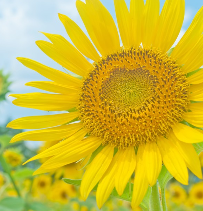

In [6]:
img = PIL.Image.open("images/himawari.png")
img.resize(np.array(img.size)//4)

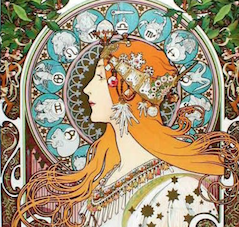

In [7]:
img = PIL.Image.open("images/Mucha.png")
img.resize(np.array(img.size)//1)

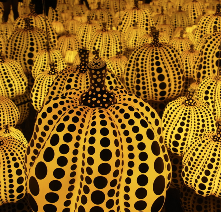

In [9]:
img = PIL.Image.open("images/kusama.png")
img.resize(np.array(img.size)//2)

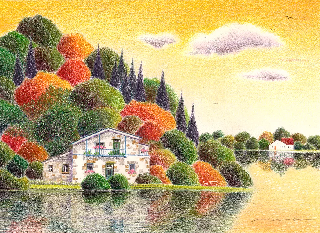

In [10]:
msurl =  'https://goo.gl/ZCnjHJ'
img = url2img(msurl)
img.resize(np.array(img.size)//3)

257.0 126.0 (962, 700)


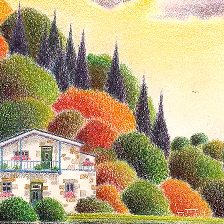

In [11]:
#　crop の場合
crop = 2
x1 = int(img.width-224*crop)/2
y1 = int(img.height-224*crop)/2
print(x1,y1,img.size)
if x1 > 0 and y1 >0 :
    cbox = (x1,y1,x1+224*crop,y1+224*crop)
    img2 = img.crop(cbox)            
img2.resize(np.array(img2.size)//crop)

# まず基本
参照原画に似せる項のみ。当然ながらただちに原画そのものになる。ボケてるのは、ぼかして使っているから。

mkdir: ex0: File exists


Original image set images/himawari.png
Style image set images/Mucha.png


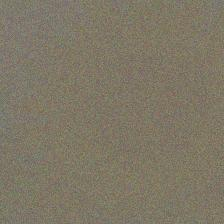

   19  1546.01367  = 0.00000 +0.00000+ 1546.01367  ( 0.00000  0.00000  -131.02820)
   20  1546.01367  = 0.00000 +0.00000+ 1546.01367


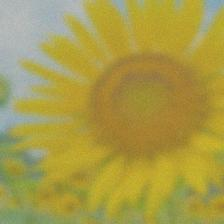

In [185]:
!mkdir ex0
lr = np.float32(2000.0) # 学習係数
rr1 = np.float32(0.00)
rr2 = np.float32(0.00)
generate(nn,"images/himawari.png","images/Mucha.png",itr=20, fn="ex0", interval=20)

# 原画の３，４層特徴のみ

mkdir: ex1: File exists


Original image set images/himawari.png
Style image set images/Mucha.png


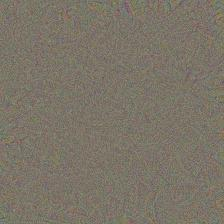

   25  8311.65430  = 8311.65430 +0.00000+ 0.00000  ( 274.20801  0.00000  0.00000 (0))))))

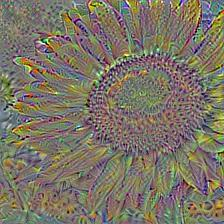

   49  5648.72314  = 5648.72314 +0.00000+ 0.00000  ( -21.57568  0.00000  0.00000 (0)))
   50  5648.72314  = 5648.72314 +0.00000+ 0.00000


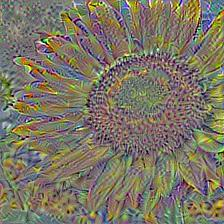

In [188]:
!mkdir ex1
lr = np.float32(200.0) # 学習係数
rr1 = np.float32(1.)
rr2 = np.float32(0.)
generate(nn,"images/himawari.png","images/Mucha.png",itr=50, fn="ex1",interval=25)

# スタイル画像特徴のみ

## Musha

mkdir: ex2: File exists


Original image set images/himawari.png
Style image set images/Mucha.png


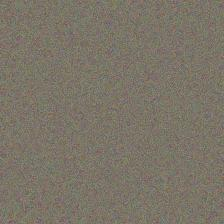

   29  3726.64624  = 0.00000 +3726.64624+ 0.00000  ( 0.00000  -113.90283  0.00000 (0)))2))
   30  3726.64624  = 0.00000 +3726.64624+ 0.00000


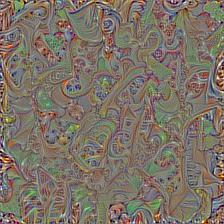

In [189]:
!mkdir ex2
lr = np.float32(100.0) # 学習係数    200 だと発散した
rr1 = np.float32(0.00)
rr2 = np.float32(1)
generate(nn,"images/himawari.png","images/Mucha.png",itr=30, fn="ex2",interval=30)

#  草間彌生 

mkdir: ex３: File exists


Original image set images/himawari.png
Style image set images/kusama.png


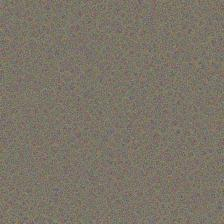

   23  62055.05078  = 0.00000 +62055.05078+ 0.00000  ( 0.00000  22367.33984  0.00000 (2)))))ロスが増えつづけているので停止

   24  62055.05078  = 0.00000 +62055.05078+ 0.00000


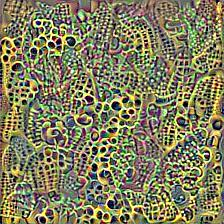

In [190]:
!mkdir ex３
lr = np.float32(100.0) # 学習係数
rr1 = np.float32(0.00)
rr2 = np.float32(1)
generate(nn,"images/himawari.png","images/kusama.png",itr=30, fn="ex3",interval=30)

# Mikako 

mkdir: ex4: File exists


Original image set images/himawari.png
Style image set https://goo.gl/ZCnjHJ


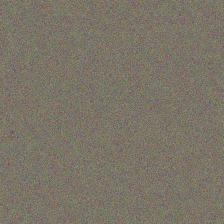

   29  2723.74585  = 0.00000 +2723.74585+ 0.00000  ( 0.00000  -87.51099  0.00000 (0))))))
   30  2723.74585  = 0.00000 +2723.74585+ 0.00000


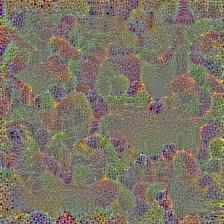

In [191]:
!mkdir ex4
lr = np.float32(100.0) # 学習係数
rr1 = np.float32(0.00)
rr2 = np.float32(1)
generate(nn,"images/himawari.png",msurl,itr=30, fn="ex4", interval=30)

mkdir: ex6: File exists


Original image set images/himawari.png
Style image set images/Mucha.png


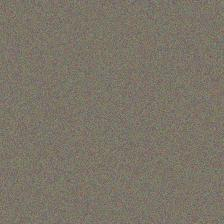

  199  5837.72363  = 3769.76416 +2067.95972+ -0.00012  ( -4.00781  -4.27026  -0.00000 (0))))))))

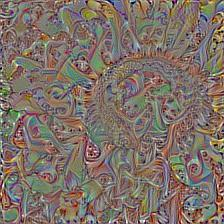

  399  4855.19873  = 3236.05444 +1619.14429+ -0.00012  ( -1.80176  -1.19299  -0.00000 (0))
  400  4855.19873  = 3236.05444 +1619.14429+ -0.00012


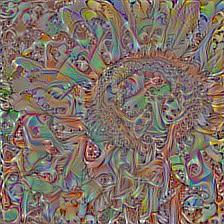

In [194]:
#  loss3 を０   ->  chainer-goph と同じ　　　ただし重みパラメータは適当
!mkdir ex6
lr = np.float32(50.0) # 学習係数
rr1 = np.float32(0.2)
rr2 = np.float32(0.8)
generate(nn,"images/himawari.png","images/Mucha.png",l1=['pool4'],itr=400, fn="ex6",interval=200)

mkdir: ex9: File exists
Original image set himawari.png
Style image set Mucha.png

0  8879.70801  = 681.5145874023 +1318.1292724609+ 6880.0646809453


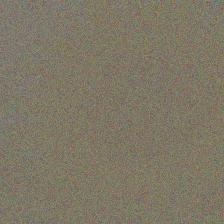

01234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
200   615.74097  = 185.6664733887 +253.9665832520+ 176.1079027340


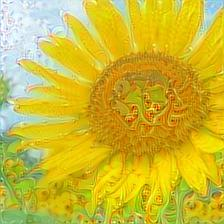

01234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
399  6.16209e+02  = 1.91599e+02 +2.47779e+02+ 1.76830e+02


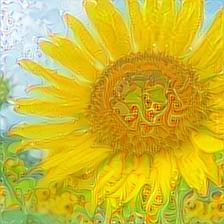

In [19]:
!mkdir ex9
lr = np.float32(2000.0) # 学習係数
rr1 = np.float32(0.02)
rr2 = np.float32(0.03)
generate(nn,"images/himawari.png","images/Mucha.png",itr=400, fn="ex9",interval=200)

mkdir: ex10: File exists
Original image set himawari.png
Style image set kusama.png

0  15375.11035  = 681.3081054688 +7816.6289062500+ 6877.1729328950


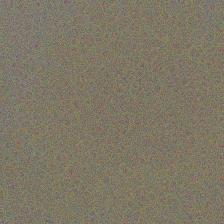

01234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
200  2824.68311  = 479.9538269043 +1585.0139160156+ 759.7154183742


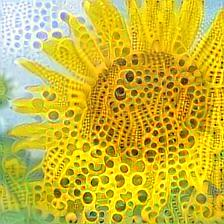

01234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
399  3.22727e+03  = 4.43626e+02 +2.00047e+03+ 7.83174e+02


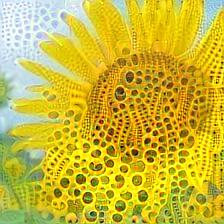

In [20]:
!mkdir ex10
lr = np.float32(2000.0) # 学習係数
rr1 = np.float32(0.02)
rr2 = np.float32(0.03)
generate(nn,"images/himawari.png","images/kusama.png",itr=400, fn="ex10",interval=200)

mkdir: ex11: File exists


Original image set images/himawari.png
Style image set https://goo.gl/ZCnjHJ


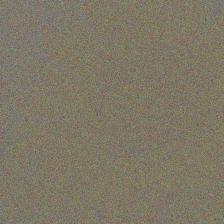

   34  989.76703  = 207.57167 +173.85246+ 608.34291  ( -5.78673  1.04051  -37.53422))5)4))評価基準を超えた


NameError: name 'goto' is not defined

In [176]:
!mkdir ex11
lr = np.float32(2000.0) # 学習係数
rr1 = np.float32(0.02)
rr2 = np.float32(0.03)
generate(nn,"images/himawari.png",msurl,itr=400, fn="ex11",interval=200)

In [149]:
np.array((1,2,3))[0].astype(np.float32)

1.0

In [ ]:
!mkdir ex12
lr = np.float32(2000.0) # 学習係数
rr1 = np.float32(0.02)
rr2 = np.float32(0.03)
generate(nn,"himawari.png",msurl,crop=3,itr=50, fn="ex12")

In [ ]:
!mkdir tes
lr = np.float32(500.0) # 学習係数
rr1 = np.float32(0.1)
rr2 = np.float32(0.25)
generate(nn,"images/Quebec.jpg","images/mstyle.png",itr=50, interval=10,fn="ex12")

Original image set Quebec.jpg
Style image set mstyle.png

500  3473.00293  = 960.4979858398 +526.8209838867+ 1985.6838007956


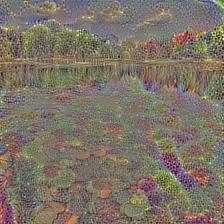

0123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
600  2792.40405  = 770.7404174805 +489.7786254883+ 1531.8850488108


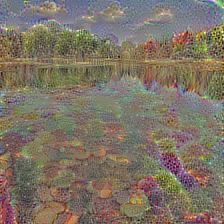

0123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
700  2343.47241  = 674.4423828125 +466.4796447754+ 1202.5504317734


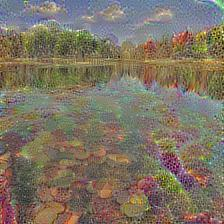

0123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
800  2026.60535  = 613.0992431641 +453.4892578125+ 960.0168395723


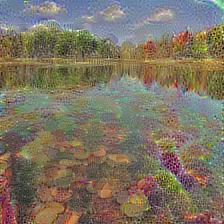

0123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
900  1795.98462  = 571.5570678711 +445.2240905762+ 779.2034740277


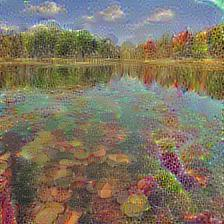

0123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
999  1.62681e+03  = 5.41983e+02 +4.40002e+02+ 6.44822e+02


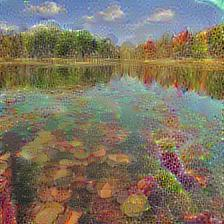

In [23]:
lr = np.float32(100.0) # 学習係数
rr1 = np.float32(0.1)
rr2 = np.float32(0.2)
generate(nn,"Quebec.jpg","mstyle.png",cont = True,itr=500, interval=100,fn="ex12",start=500)

Original image set Quebec.jpg
Style image set mstyle.png

500  2331.19482  = 1083.1954345703 +880.1969604492+ 367.8024575993


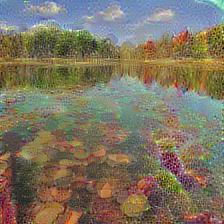

0123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
600  2182.37378  = 992.2636108398 +837.7481689453+ 352.3620038428


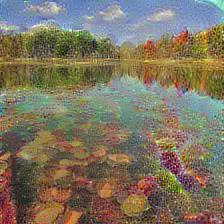

0123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
700  2093.37646  = 947.1928100586 +814.0870361328+ 332.0966478505


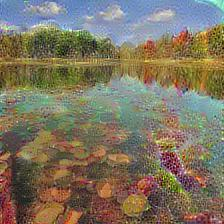

0123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
800  2031.73096  = 917.9288330078 +799.9462890625+ 313.8557791176


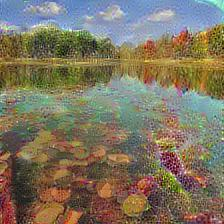

0123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
900  1984.71753  = 900.6690673828 +786.0006103516+ 298.0478693147


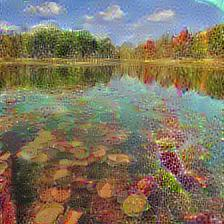

0123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
999  1.95125e+03  = 8.78637e+02 +7.88081e+02+ 2.84535e+02


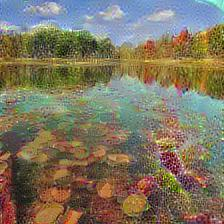

In [24]:
lr = np.float32(100.0) # 学習係数
rr1 = np.float32(0.2)
rr2 = np.float32(0.4)
generate(nn,"Quebec.jpg","mstyle.png",cont = True,itr=500, interval=100,fn="tes",start=500)

In [26]:
!convert -delay 12 -loop 0 -resize 300x tes/*.png tes.gif

In [116]:
a = np.array((1))

In [117]:
a

array(1)

In [118]:
a.val

AttributeError: 'numpy.ndarray' object has no attribute 'val'

In [133]:
a = np.array([1e+30,1e+30,1e+30,1e+30])

In [135]:
print("{:4f}".format(a[0]))

1000000000000000019884624838656.000000


In [137]:
type(a[0])

numpy.float64